In [4]:
import os
import functools
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

if "OUTPUT_RETINA_IMAGES" in os.environ:
    %config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

We generate a dataset using sin(2πx) function but also add some observation noise to reflect the true world !

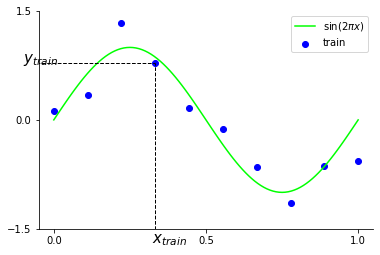

In [5]:
N = 10
SEED = 1234
SCALE = 0.25

np.random.seed(SEED)

def true_fun(x):
    return np.sin(2 * np.pi * x)

def generate_noisy_data(x, scale=SCALE):
    y = true_fun(x) + np.random.normal(scale=scale, size=x.shape)
    return y

x_plot = np.arange(0, 1.01, 0.01)
y_plot = true_fun(x_plot)

# points with noise, will act as train data
x_train = np.linspace(0, 1, N)
y_train = generate_noisy_data(x_train)

plt.plot(x_plot, y_plot, color='lime', label="$\sin(2\pi x)$")
plt.scatter(x_train, y_train, marker='o', color='blue', label="train")
plt.hlines(y=y_train[3], xmin=-2, xmax=x_train[3], linewidth=1, linestyle='--', color = 'k')
plt.vlines(x=x_train[3], ymin=-2, ymax=y_train[3], linewidth=1, linestyle='--', color = 'k')

plt.text(-0.1, y_train[3], "$y_{train}$", fontsize=15)
plt.text(x_train[3] - 0.01, -1.7, "$x_{train}$", fontsize=15)
plt.yticks( [-1.5, 0.0, 1.5] )
plt.xticks( [0.0, 0.5, 1.0] )
plt.xlim(-0.05, 1.05)
plt.ylim(-1.5, 1.5)
plt.legend()

We will now use different models of regression to determine the weights. These models will differ by the degree of polynomial so as a first step let’s transform our features (xtrain)

In [6]:
def transform_features(X, m):
    """ Create a polynomial of specified degrees """
    return PolynomialFeatures(degree=m).fit_transform(X.reshape(-1, 1))

# examples of creating the polynomial features
features_m_0 = transform_features(x_train, m=0)
features_m_1 = transform_features(x_train, m=1)
features_m_3 = transform_features(x_train, m=3)
features_m_9 = transform_features(x_train, m=9)

In [7]:
def multiple_regression_fit(features, y_train):
    A_t = features.T @ features 
    weight_vector = np.linalg.solve(A_t, features.T @ y_train)
    return weight_vector

def multiple_regression_predict(features, weight_vector):
    return np.dot(features, weight_vector)

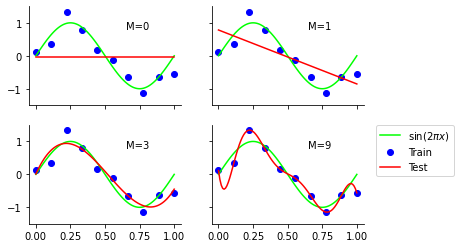

In [8]:
# we will invoke above fit & predict methods in a loop for all
# the polynomials

# test data
# x that we used to draw out sin function will act as the test data

def regress(m, x, y):
    poly_train_features = transform_features(x, m=m)
    return multiple_regression_fit(poly_train_features, y)
    
def predict(m, x, weight_vector):
    poly_test_features = transform_features(x, m=m)
    return multiple_regression_predict(poly_test_features, weight_vector)

def regress_and_predict(m, x_train, y_train, x_test):
    weight_vector = regress(m, x_train, y_train)
    return predict(m, x_test, weight_vector)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

plt.xlim(-0.05, 1.05)
plt.ylim(-1.5, 1.5)

def plot(m, x, y_predict, ax):
    # true function
    ax.plot(x_plot, y_plot, color='lime', label="$\sin(2\pi x)$")

    # training data
    ax.scatter(x_train, y_train, marker='o', color='blue', label="Train")

    # Show the poly degree
    ax.text(0.65, 0.8, f"M={m}")

    # finally the predictions
    ax.plot(x, y_predict, color='red', label="Test")


x_test = np.linspace(0, 1, 100)
y_test = generate_noisy_data(x_test)

partial_rp = functools.partial(regress_and_predict, 
                        x_train=x_train, 
                        y_train=y_train, 
                        x_test=x_test)

results = list(map(partial_rp, [0,1,3,9]))

plot(m=0, x=x_test, y_predict=results[0], ax=ax[0][0])
plot(m=1, x=x_test, y_predict=results[1], ax=ax[0][1])
plot(m=3, x=x_test, y_predict=results[2], ax=ax[1][0])
plot(m=9, x=x_test, y_predict=results[3], ax=ax[1][1])

plt.legend(bbox_to_anchor=(1.05, 1.05))

Notes -

Red curve shows the fitted curve.

M=0 fails to create the sin curve

M=1 also failed

M=3 seems to re-create the curve close to original function

M=9 creates a curve that passes through all the training data but fails to approximate sin and is very wiggly. This is overfitting.

Evaluating residual value of E(w∗)

Text(0, 0.5, 'RMSE')

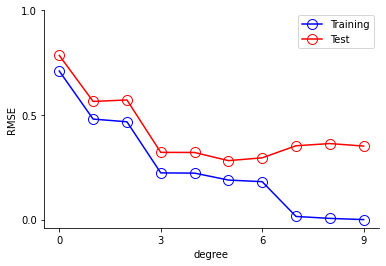

In [9]:
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

# try polynomial of degrees from 0 to 10
M = range(0, 10)

weight_vectors = []
for m in M:
    w = regress(m=m, x=x_train, y=y_train)
    weight_vectors.append(w)
    
def compute_errors(x, y, m, weight_vector):
    y_predict = predict(m=m, x=x, weight_vector=weight_vector)
    return rmse(y_predict, y)

def accumate_errors(x, y):
    m_w = zip(M, weight_vectors)
    errors = []
    for (m, w) in m_w:
        errors.append(compute_errors(x, y, m, w))
    return errors

x_test = np.arange(0, 1.01, 0.01)
y_test = generate_noisy_data(x_test)

training_errors = accumate_errors(x_train, y_train)
test_errors = accumate_errors(x_test, y_test)

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.yticks( [0,0.5,1] )
plt.xticks( [0,3,6,9] )
plt.xlabel("degree")
plt.ylabel("RMSE")